In [6]:
# EXPLORATORY ANALYSIS, DATA VALIDATION, AND FINANCIAL ANALYSIS OF CLIPBOARD HEALTH DATA.
# COMPLETED AS PART OF THE INTERVIEW SCREENING PROCESS.

#Importing various packages for data analysis

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib import ticker

# Statistics
from scipy.stats import pearsonr

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_excel('/kaggle/input/connect-shift/connect_shift_python.xlsx')

                                        🔍 DATA FIRST GLANCE

📌 First row of the dataset:
                   SHIFT_ID                 WORKER_ID  \
0  6757580b1e2d97752fd69167  65b01f2e46c0645699081cbe   

               WORKPLACE_ID      SHIFT_START_AT        SHIFT_CREATED_AT  \
0  5e7e45243bfbb200165914ae 2024-12-09 23:00:00 2024-12-09 20:50:19.271   

          OFFER_VIEWED_AT  DURATION SLOT CLAIMED_AT DELETED_AT  IS_VERIFIED  \
0 2024-12-09 21:18:42.297         8   pm        NaT        NaT        False   

  CANCELED_AT  IS_NCNS  PAY_RATE  CHARGE_RATE  REVENUE  
0         NaT    False     21.29           29     7.71  


📋 Data types of each column:
SHIFT_ID                    object
WORKER_ID                   object
WORKPLACE_ID                object
SHIFT_START_AT      datetime64[ns]
SHIFT_CREATED_AT    datetime64[ns]
OFFER_VIEWED_AT     datetime64[ns]
DURATION                     int64
SLOT                        object
CLAIMED_AT          datetime64[ns]
DELETED_AT          dateti

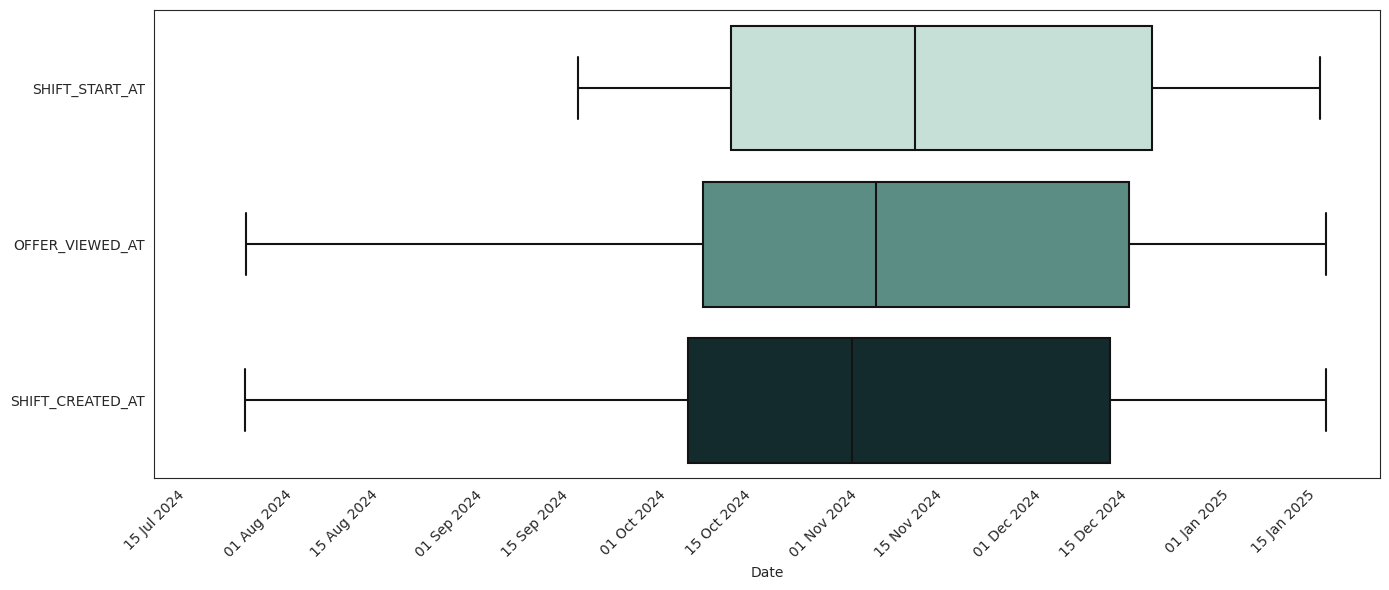

In [25]:
                            # === DATA FIRST GLANCE ===

print("=" * 95)
print(" " * 40 + "🔍 DATA FIRST GLANCE")
print("=" * 95)

print("\n📌 First row of the dataset:")
print(df.head(1))

print("\n" + "=" * 50)
print("\n📋 Data types of each column:")
print(df.dtypes)

print("\n" + "=" * 50)
total_obs = df.shape[0]
print("\n📊 Total observations in dataset:", total_obs)

print("\n" + "=" * 50)
unique_counts = df[['SHIFT_ID', 'WORKER_ID', 'WORKPLACE_ID', 'SLOT']].nunique()
print("\n🔢 Number of unique values per key column:")
print(unique_counts)


# ===  SHIFT CREATION, VIEWS & SCHEDULE ===

print("=" * 95)
print(" " * 10 + "🔍 EXPLORATORY DATA ANALYSIS - SHIFTS CREATION, VIEWS & SCHEDULE")
print("=" * 95)

print("\n📅 Shift creation date range:")
print("   - First created shift:", df['SHIFT_CREATED_AT'].min())
print("   - Last created shift :", df['SHIFT_CREATED_AT'].max())

print("\n" + "=" * 50)
print("\n👀 Offer viewing period:")
print("   - First viewed offer:", df['OFFER_VIEWED_AT'].min())
print("   - Last viewed offer :", df['OFFER_VIEWED_AT'].max())

print("\n" + "=" * 50)
print("\n🕒 Shift working period:")
print("   - Earliest shift start:", df['SHIFT_START_AT'].min())
print("   - Latest shift start  :", df['SHIFT_START_AT'].max())

print("\n" + "=" * 95 + "\n")

# Convert to datetime
df['SHIFT_CREATED_AT'] = pd.to_datetime(df['SHIFT_CREATED_AT'])
df['SHIFT_START_AT'] = pd.to_datetime(df['SHIFT_START_AT'])
df['OFFER_VIEWED_AT'] = pd.to_datetime(df['OFFER_VIEWED_AT'])

# Melt timestamps for plotting
melted = pd.melt(
    df[['SHIFT_CREATED_AT', 'SHIFT_START_AT', 'OFFER_VIEWED_AT']],
    var_name='Timestamp Type',
    value_name='Datetime'
)
melted['DatetimeNum'] = date2num(melted['Datetime'])

# Plotting order and color setup
order = ['SHIFT_START_AT', 'OFFER_VIEWED_AT', 'SHIFT_CREATED_AT']
palette = sns.color_palette('ch:s=-.5,r=-.1', len(order))
color_dict = dict(zip(order, palette))

# Plot
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=melted,
    x='DatetimeNum',
    y='Timestamp Type',
    orient='h',
    order=order,
    palette=color_dict,
    showfliers=True
)

# Custom x-ticks: 1st & 15th of each month
tick_dates = pd.date_range(start='2024-07-15', end='2025-01-15', freq='D')
tick_dates = [d for d in tick_dates if d.day in [1, 15]]
tick_nums = date2num(tick_dates)

ax = plt.gca()
ax.set_xticks(tick_nums)
ax.set_xticklabels([d.strftime('%d %b %Y') for d in tick_dates], rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

plt.xlabel("Date")
plt.ylabel("")
plt.tight_layout()
plt.show()



In [26]:
            # SUMMARY STATISTICS OF NUMBER OF SHIFTS, VIEWS, ETC.

# Summary stats of count of OFFER_VIEWED_AT, grouped by SHIFT_ID
offer_viewed_by_shift = df.groupby('SHIFT_ID')['OFFER_VIEWED_AT'].count().reset_index(name='offer_viewed_count')
summary_stats_shift = offer_viewed_by_shift['offer_viewed_count'].describe().round(2)
print("Summary Statistics of views per available shift:\n", summary_stats_shift)

# Summary stats of count of OFFER_VIEWED_AT, grouped by WORKER_ID
# Group by both WORKER_ID and SHIFT_ID, and count OFFER_VIEWED_AT
offer_viewed_by_worker_shift = df.groupby(['SHIFT_ID','WORKER_ID'])['OFFER_VIEWED_AT'].count().reset_index(name='offer_viewed_count')
summary_stats_worker = offer_viewed_by_worker_shift['offer_viewed_count'].describe().round(2)
print("\nSummary Statistics views per worker per shift:\n", summary_stats_worker)

# Summary stats of count of unique SHIFT_IDs, grouped by WORKPLACE_ID
unique_shift_by_workplace = df.groupby('WORKPLACE_ID')['SHIFT_ID'].nunique().reset_index(name='unique_shift_count')
summary_stats_workplace = unique_shift_by_workplace['unique_shift_count'].describe().round(2)
print("\nSummary Statistics of shifts posted [er workplace:\n", summary_stats_workplace)

# === DATA VALIDATION: SHIFT CREATION BEFORE START ===

print("=" * 95)
print(" " * 5 + "🔍 DATA VALIDATION - SHIFTS CREATED BEFORE START")
print("=" * 95)

df_shifts = df[['SHIFT_ID', 'WORKPLACE_ID', 'SHIFT_START_AT', 'SHIFT_CREATED_AT', 'DURATION', 'SLOT', 'CHARGE_RATE']]
df_shifts = df_shifts.drop_duplicates()

df_shifts['interval_days'] = (df_shifts['SHIFT_START_AT'] - df_shifts['SHIFT_CREATED_AT']).dt.total_seconds() / (24 * 3600)

total_obs = df_shifts.shape[0]
print(f"\n📊 Total number of shifts created: {total_obs}")

summary_all = df_shifts['interval_days'].describe().round(2)
print("\n📈 Summary of days between shift creation and shift start:")
print(summary_all)

# Shifts created after their start
df_shifts_filtered = df_shifts[df_shifts['interval_days'] <= 0]
total_filtered = df_shifts_filtered.shape[0]

# Workplaces with invalid shifts
df_workplaceerrors = df_shifts_filtered.groupby('WORKPLACE_ID').size().reset_index(name='invalid_shifts')
total_workplaces = df_workplaceerrors.shape[0]

print(f"🏥 Workplaces that posted invalid shifts: {total_workplaces}")
print("\nTop 5 workplaces with invalid shifts:")
print(df_workplaceerrors.sort_values(by='invalid_shifts', ascending=False).head())


Summary Statistics of views per available shift:
 count    19900.00
mean        13.38
std         24.42
min          1.00
25%          1.00
50%          3.00
75%         14.00
max        335.00
Name: offer_viewed_count, dtype: float64

Summary Statistics views per worker per shift:
 count    254757.00
mean          1.05
std           0.22
min           1.00
25%           1.00
50%           1.00
75%           1.00
max           4.00
Name: offer_viewed_count, dtype: float64

Summary Statistics of shifts posted [er workplace:
 count     132.00
mean      150.76
std       253.42
min         1.00
25%        13.75
50%        56.50
75%       151.00
max      1779.00
Name: unique_shift_count, dtype: float64
     🔍 DATA VALIDATION - SHIFTS CREATED BEFORE START

📊 Total number of shifts created: 19900

📈 Summary of days between shift creation and shift start:
count    19900.00
mean         6.83
std          9.51
min        -36.29
25%          0.52
50%          3.03
75%          8.94
max         75

Shifts On average there were 56 shifts created per workplace, with a minimum of 1 shift and a maximum of 1779 shifts per work place. Shift Creation timeline On average, shifts were created 2.5 to 3 days before their scheduled start time, with a maximum lead-time ranging upto 75 days. However, there were 47 shifts that were created 0.5 hrs to 36 days after the shift had already started. These late-created shifts came from 15 different workplaces. There is one workplace that posted 20 shifts after the shift had actually started, followed by other workplaces that posted 6 and 4 late shifts. Shares per shift On average each shift is shared (viewed) 3 times, with a minimum of 1 share to a maximum of 335 shares per shift. On average each shift was viewed 1 time per worker, with maximum of up to 4 views.

          🔍 EXPLORATORY DATA ANALYSIS  - TRENDS IN AVAILABLE SHIFTS AND SHIFT VIEWS

🔹 Total Available Shifts: 19,900
🔹 Total Worked Shifts   : 12,541

📊 Daily Shifts Summary Statistics:
        Available Shifts  Worked Shifts
count            121.00         121.00
mean             164.46         104.54
std               43.70          26.89
min               93.00          55.00
25%              129.00          84.00
50%              161.00         102.00
75%              191.00         119.00
max              266.00         201.00

🗓️ Monthly Shift Breakdown:
          Available Shifts  Worked Shifts
MONTH                                   
2024-09              1746           1074
2024-10              5771           3517
2024-11              4436           2856
2024-12              4746           3175
2025-01              3201           2027

📊 Summary Statistics: Offer Views per Verified Shift
 count    12541.00
mean         7.09
std         14.72
min          1.00
25%          1.00

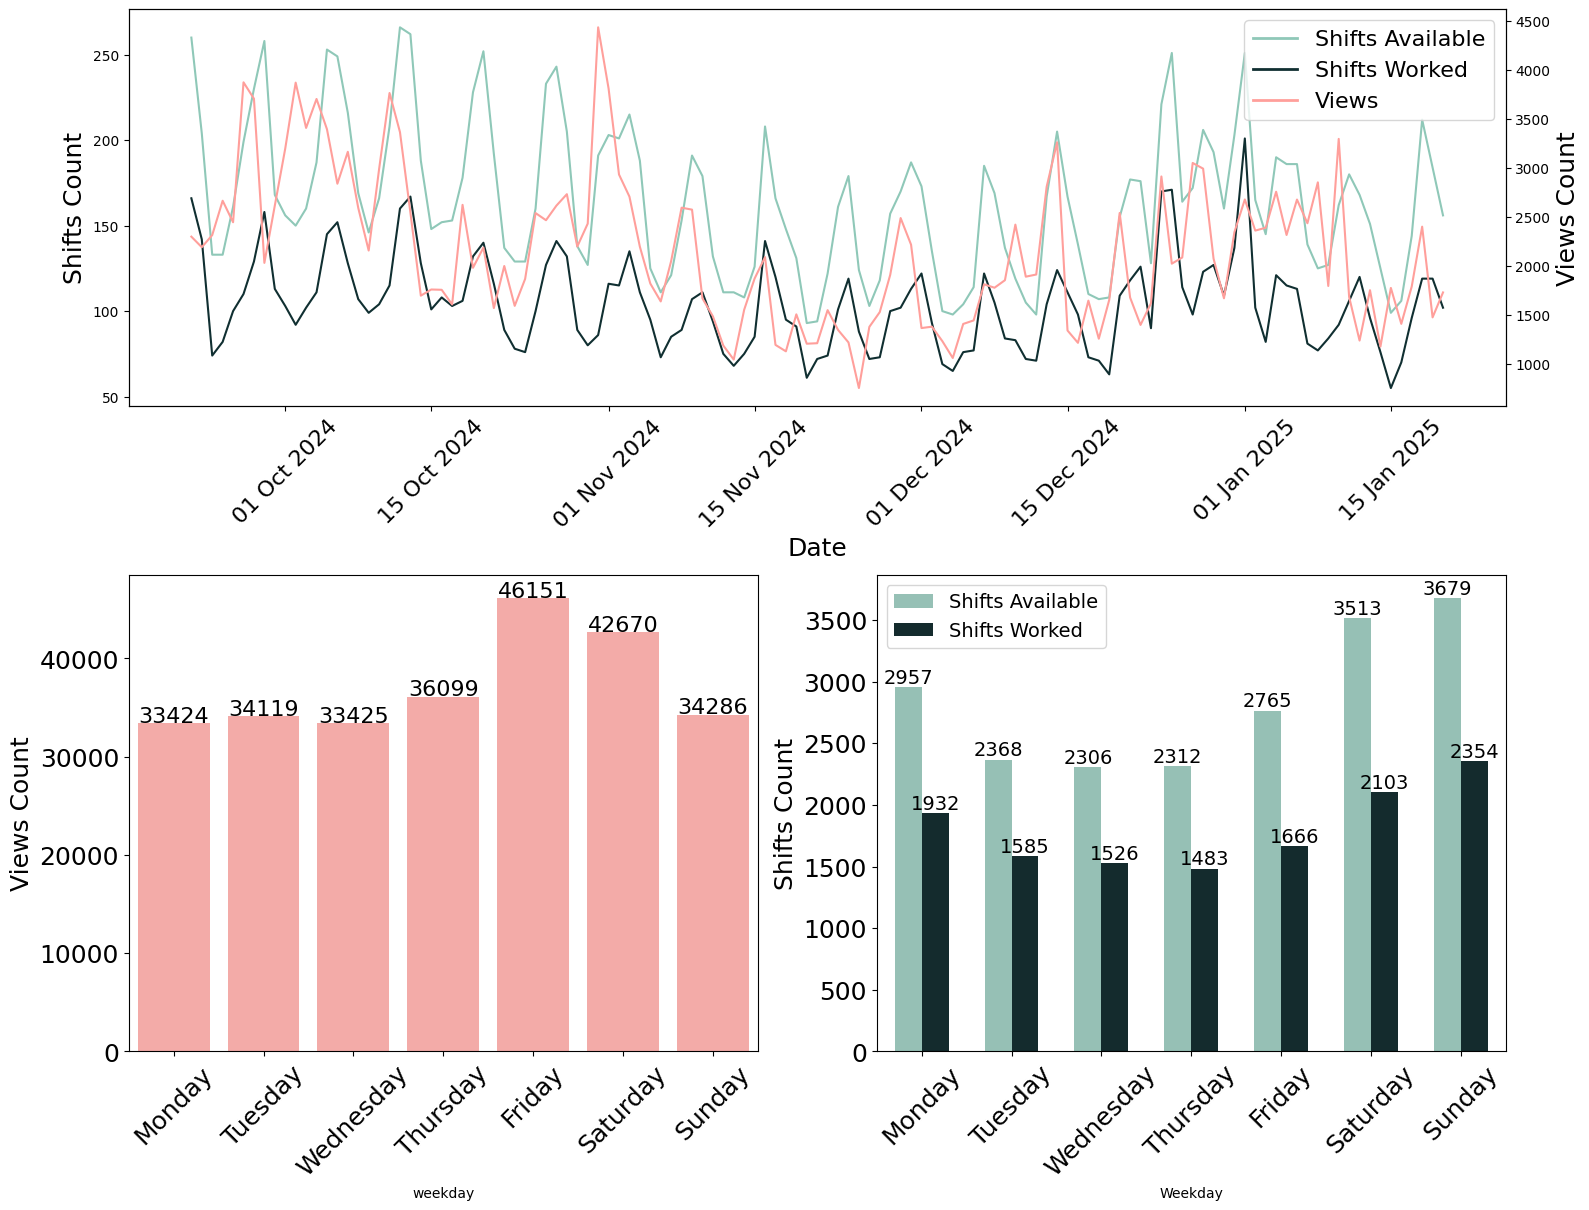

In [4]:
            #ANALYSIS ON SHIFTS AVAILABLE, SHIFTS WORKED AND NUMBER OF VIEWS

print("="*95)
print(" "*10 + "🔍 EXPLORATORY DATA ANALYSIS  - TRENDS IN AVAILABLE SHIFTS AND SHIFT VIEWS")
print("="*95)

# --- Prepare Shift Data ---
df_shifts = df[['SHIFT_ID', 'WORKPLACE_ID', 'SHIFT_START_AT', 'SHIFT_CREATED_AT', 'DURATION', 'CHARGE_RATE']].drop_duplicates()
df_shifts['SHIFT_START_AT'] = pd.to_datetime(df_shifts['SHIFT_START_AT'])
df_shifts['SHIFT_DATE'] = df_shifts['SHIFT_START_AT'].dt.date
daily_counts = df_shifts.groupby('SHIFT_DATE').size().reset_index(name='shift_count')
daily_counts['SHIFT_DATE'] = pd.to_datetime(daily_counts['SHIFT_DATE'])

# --- Offer Views Data ---
df['OFFER_VIEWED_AT'] = pd.to_datetime(df['OFFER_VIEWED_AT'])
daily_offer_views = df['OFFER_VIEWED_AT'].dt.date.value_counts().sort_index().reset_index()
daily_offer_views.columns = ['date', 'offer_views']
daily_offer_views['date'] = pd.to_datetime(daily_offer_views['date'])

# --- Merge Shift and View Data ---
merged_df = pd.merge(daily_offer_views, daily_counts, left_on='date', right_on='SHIFT_DATE', how='inner')

# --- Verified Shifts ---
verified_daily = df[df['IS_VERIFIED'] == True]['SHIFT_START_AT'].dt.date.value_counts().sort_index().reset_index()
verified_daily.columns = ['date', 'verified_count']
verified_daily['date'] = pd.to_datetime(verified_daily['date'])

# Add verified counts to merged_df
merged_df = pd.merge(merged_df, verified_daily, on='date', how='left')

# --- Shift Summary Stats ---
total_available_shifts = df_shifts['SHIFT_ID'].nunique()
total_worked_shifts = df[df['IS_VERIFIED'] == True]['SHIFT_ID'].nunique()

available_per_day = df_shifts.groupby('SHIFT_DATE').size()
worked_per_day = df[df['IS_VERIFIED'] == True]['SHIFT_START_AT'].dt.date.value_counts().sort_index()

df_shifts['MONTH'] = df_shifts['SHIFT_START_AT'].dt.to_period('M')
available_per_month = df_shifts.groupby('MONTH').size()

df_worked = df[df['IS_VERIFIED'] == True].copy()
df_worked['MONTH'] = df_worked['SHIFT_START_AT'].dt.to_period('M')
worked_per_month = df_worked.groupby('MONTH').size()

print(f"\n🔹 Total Available Shifts: {total_available_shifts:,}")
print(f"🔹 Total Worked Shifts   : {total_worked_shifts:,}")

summary_comparison = pd.DataFrame({
    'Available Shifts': available_per_day.describe().round(2),
    'Worked Shifts': worked_per_day.describe().round(2)
})
print("\n📊 Daily Shifts Summary Statistics:\n", summary_comparison)

monthly_summary = pd.DataFrame({
    'Available Shifts': available_per_month,
    'Worked Shifts': worked_per_month
}).fillna(0).astype(int)
print("\n🗓️ Monthly Shift Breakdown:\n", monthly_summary)

# --- Offer Views per Verified Shift ---
verified_shifts = df[df['IS_VERIFIED'] == True][['SHIFT_ID']].drop_duplicates()
offers_on_verified = df.merge(verified_shifts, on='SHIFT_ID', how='inner')
offers_on_verified['OFFER_VIEWED_AT'] = pd.to_datetime(offers_on_verified['OFFER_VIEWED_AT'])
views_per_shift = offers_on_verified.groupby('SHIFT_ID')['OFFER_VIEWED_AT'].count()
print("\n📊 Summary Statistics: Offer Views per Verified Shift\n", views_per_shift.describe().round(2))

# --- Lead Time Analysis ---
verified_df = df[df['IS_VERIFIED'] == True].copy()
verified_df['SHIFT_CREATED_AT'] = pd.to_datetime(verified_df['SHIFT_CREATED_AT'])
verified_df['SHIFT_START_AT'] = pd.to_datetime(verified_df['SHIFT_START_AT'])
verified_df['CLAIMED_AT'] = pd.to_datetime(verified_df['CLAIMED_AT'])

verified_df['posting_in_advance'] = (verified_df['SHIFT_START_AT'] - verified_df['SHIFT_CREATED_AT']).dt.days
verified_df['claim_in_advance'] = (verified_df['CLAIMED_AT'] - verified_df['SHIFT_CREATED_AT']).dt.days

print("\n📅 Summary - Days Posted in Advance (Verified Shifts):\n", verified_df['posting_in_advance'].describe().round(2))
print("\n📅 Summary - Days Claimed in Advance (Verified Shifts):\n", verified_df['claim_in_advance'].dropna().describe().round(2))

# --- Weekday Trends ---
merged_df['weekday'] = merged_df['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shifts_by_day = merged_df.groupby('weekday')['shift_count'].sum().reindex(weekday_order)
views_by_day = merged_df.groupby('weekday')['offer_views'].sum().reindex(weekday_order)
verified_by_day = merged_df.groupby('weekday')['verified_count'].sum().reindex(weekday_order)

# --- Plotting ---
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[2.5, 3, 1])

# Line Plot
color_shift = sns.color_palette("ch:s=-.5,r=-.1", 6)[1]
color_verified = sns.color_palette("ch:s=-.5,r=-.1", 6)[5]
color_views = sns.color_palette("pastel")[3]

ax1 = fig.add_subplot(gs[0, :])
sns.lineplot(data=merged_df, x='date', y='shift_count', ax=ax1, color=color_shift, label='Shifts')
sns.lineplot(data=merged_df, x='date', y='verified_count', ax=ax1, color=color_verified, label='Worked Shifts')
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x='date', y='offer_views', ax=ax2, color=color_views, label='')

# Legends & Axis
custom_lines = [plt.Line2D([0], [0], color=c, lw=2) for c in [color_shift, color_verified, color_views]]
ax1.legend(custom_lines, ['Shifts Available', 'Shifts Worked', 'Views'], loc='upper right', fontsize=16)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
tick_dates = [d for d in pd.date_range(merged_df['date'].min(), merged_df['date'].max(), freq='D') if d.day in [1, 15]]
ax1.set_xticks(tick_dates)
ax1.set_xticklabels([d.strftime('%d %b %Y') for d in tick_dates], rotation=45, fontsize=16)
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Shifts Count', fontsize=18)
ax2.set_ylabel('Views Count', fontsize=18)

# Views by Weekday
ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(x=views_by_day.index, y=views_by_day.values, ax=ax4, color=color_views)
ax4.set_ylabel("Views Count", fontsize=18)
ax4.tick_params(axis='x', labelsize=18, rotation=45)
ax4.tick_params(axis='y', labelsize=18)
for p in ax4.patches:
    ax4.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width()/2, p.get_height()),
                 ha='center', va='center', fontsize=16, xytext=(0, 5), textcoords='offset points')

# Grouped Bar: Shifts vs Worked
ax3 = fig.add_subplot(gs[1, 1])
combined_df = pd.DataFrame({
    'Weekday': weekday_order,
    'Shifts Available': shifts_by_day.values,
    'Shifts Worked': verified_by_day.values
})
melted_combined = combined_df.melt(id_vars='Weekday', var_name='Type', value_name='Count')
sns.barplot(data=melted_combined, x='Weekday', y='Count', hue='Type', ax=ax3,
            palette=[color_shift, color_verified], width=0.6)
ax3.set_ylabel("Shifts Count", fontsize=18)
ax3.tick_params(axis='x', labelsize=18, rotation=45)
ax3.tick_params(axis='y', labelsize=18)
ax3.legend(title="", fontsize=14)
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.0f', label_type='edge', fontsize=14)

plt.tight_layout()
plt.show()



💰 TOTAL FINANCIAL SUMMARY:
🔹 Amount Charged to Workplaces: $3,470,913.00
🔹 Amount Paid to Workers      : $2,858,334.98
🔹 Revenue Made by Clipboard   : $612,578.02

📆 REVENUE BY DAY OF THE WEEK:
🔹 Monday   : $100,315.39
🔹 Tuesday  : $72,080.36
🔹 Wednesday: $47,700.36
🔹 Thursday : $66,195.18
🔹 Friday   : $92,145.33
🔹 Saturday : $117,951.97
🔹 Sunday   : $116,189.43


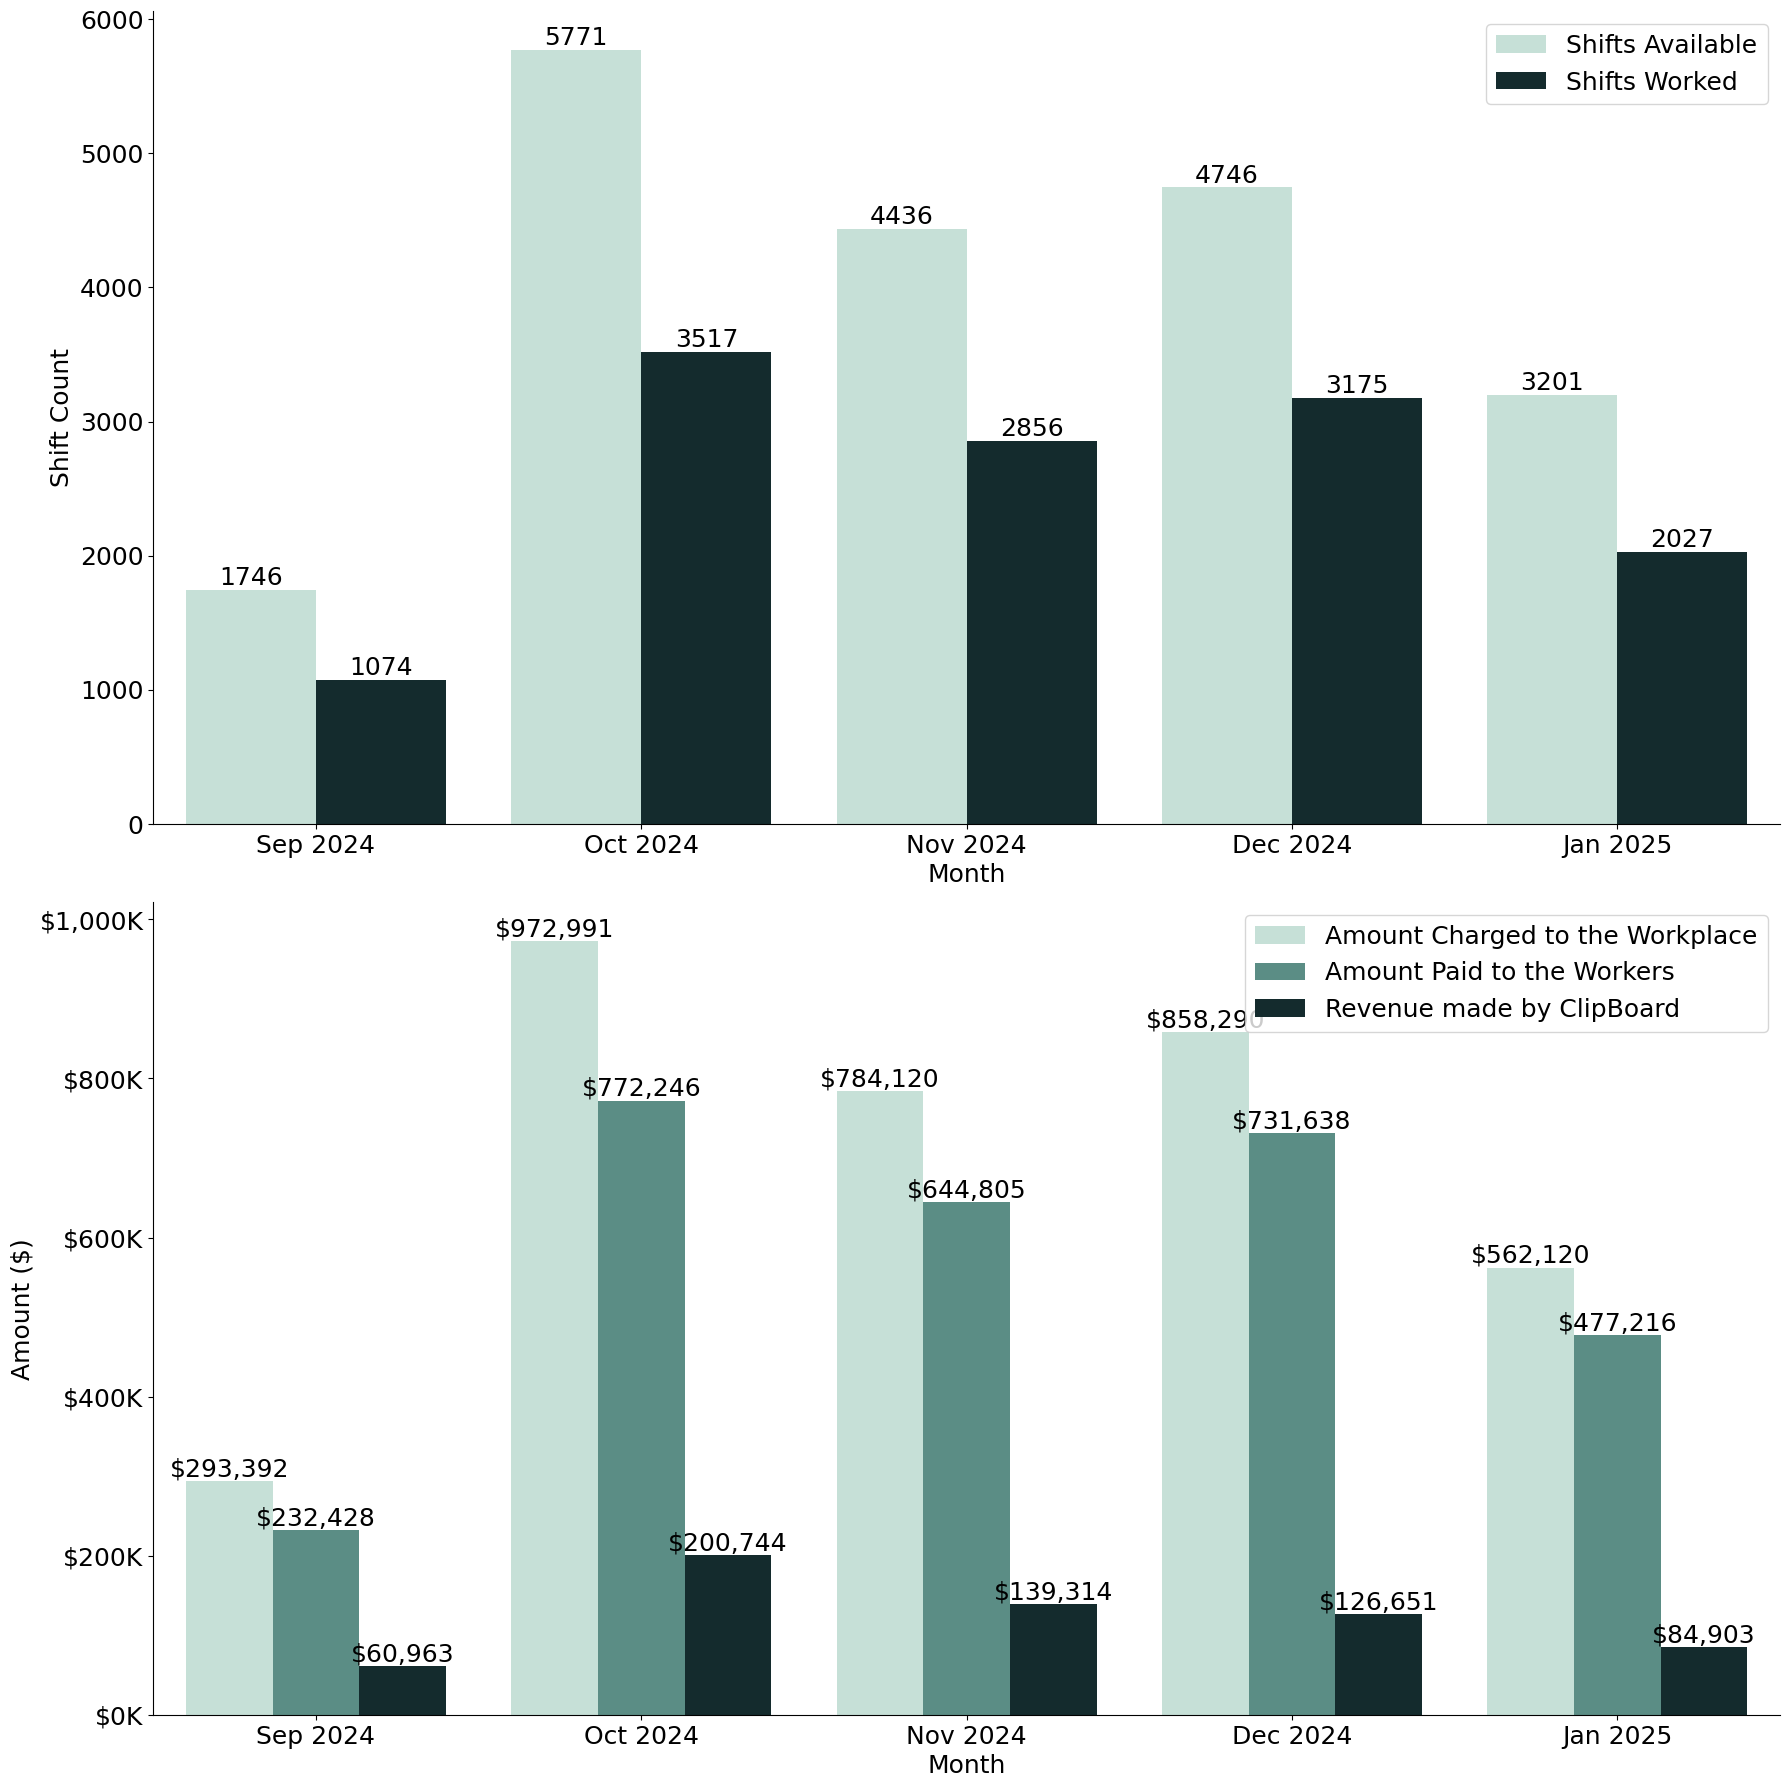

In [7]:
                        # --- ANALYSIS OF FINANCIALS ---

# 📊 Financial Summary Prep
verified_df = df[df['IS_VERIFIED'] == True].copy()
for col in ['PAY_RATE', 'CHARGE_RATE', 'DURATION']:
    verified_df[col] = pd.to_numeric(verified_df[col], errors='coerce')

verified_df = verified_df.dropna(subset=['PAY_RATE', 'CHARGE_RATE', 'DURATION', 'SHIFT_START_AT'])
verified_df['SHIFT_START_AT'] = pd.to_datetime(verified_df['SHIFT_START_AT'])

verified_df['paid_shift'] = verified_df['PAY_RATE'] * verified_df['DURATION']
verified_df['charged_shift'] = verified_df['CHARGE_RATE'] * verified_df['DURATION']
verified_df['revenue'] = verified_df['charged_shift'] - verified_df['paid_shift']
verified_df['month'] = verified_df['SHIFT_START_AT'].dt.to_period('M').dt.to_timestamp()

monthly_financials = (
    verified_df
    .groupby('month')[['charged_shift', 'paid_shift', 'revenue']]
    .sum()
    .reset_index()
)

financial_labels = {
    'charged_shift': 'Amount Charged to the Workplace',
    'paid_shift': 'Amount Paid to the Workers',
    'revenue': 'Revenue made by ClipBoard'
}

melted_financials = (
    monthly_financials
    .melt(id_vars='month', value_vars=financial_labels.keys(), var_name='Type', value_name='Amount')
    .replace({'Type': financial_labels})
)

# 💰 Total Financial Summary
total_charged = verified_df['charged_shift'].sum()
total_paid = verified_df['paid_shift'].sum()
total_revenue = verified_df['revenue'].sum()

print("\n💰 TOTAL FINANCIAL SUMMARY:")
print(f"🔹 Amount Charged to Workplaces: ${total_charged:,.2f}")
print(f"🔹 Amount Paid to Workers      : ${total_paid:,.2f}")
print(f"🔹 Revenue Made by Clipboard   : ${total_revenue:,.2f}")

# 📆 Revenue by Day of Week
verified_df['weekday'] = verified_df['SHIFT_START_AT'].dt.day_name()
revenue_by_weekday = (
    verified_df.groupby('weekday')['revenue']
    .sum()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

print("\n📆 REVENUE BY DAY OF THE WEEK:")
for day, amount in revenue_by_weekday.items():
    print(f"🔹 {day:<9}: ${amount:,.2f}")

# 📈 Shift Summary Prep
df_shifts['SHIFT_START_AT'] = pd.to_datetime(df_shifts['SHIFT_START_AT'])
df_shifts['MONTH'] = df_shifts['SHIFT_START_AT'].dt.to_period('M').dt.to_timestamp()

monthly_total = df_shifts.groupby('MONTH').size().reset_index(name='total_shifts')

df['IS_VERIFIED'] = df['IS_VERIFIED'].fillna(False)
monthly_verified = df[df['IS_VERIFIED'] == True].copy()
monthly_verified['SHIFT_START_AT'] = pd.to_datetime(monthly_verified['SHIFT_START_AT'])
monthly_verified['MONTH'] = monthly_verified['SHIFT_START_AT'].dt.to_period('M').dt.to_timestamp()
monthly_verified = monthly_verified.groupby('MONTH').size().reset_index(name='worked_shifts')

monthly_summary = pd.merge(monthly_total, monthly_verified, on='MONTH', how='left').fillna(0)
plot_df = monthly_summary.melt(id_vars='MONTH', value_vars=['total_shifts', 'worked_shifts'],
                               var_name='Type', value_name='Count')

shift_labels = {
    'total_shifts': 'Shifts Available',
    'worked_shifts': 'Shifts Worked'
}
plot_df['Type'] = plot_df['Type'].map(shift_labels)

# --- 📊 PLOTTING ---

fig, axes = plt.subplots(2, 1, figsize=(18, 18), sharex=False)
palette1 = sns.color_palette("ch:s=-.5,r=-.1", n_colors=2)
palette2 = sns.color_palette("ch:s=-.5,r=-.1", n_colors=3)

# TOP: Shift Summary
sns.barplot(data=plot_df, x='MONTH', y='Count', hue='Type', palette=palette1, ax=axes[0])
axes[0].set_xlabel("Month", fontsize=18)
axes[0].set_ylabel("Shift Count", fontsize=18)
axes[0].set_xticklabels([d.strftime('%b %Y') for d in plot_df['MONTH'].unique()], rotation=0, fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].legend(title="", fontsize=18)
axes[0].grid(False)
sns.despine(ax=axes[0])

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f', label_type='edge', fontsize=18)

# BOTTOM: Financial Summary
sns.barplot(data=melted_financials, x='month', y='Amount', hue='Type', palette=palette2, ax=axes[1])
axes[1].set_xlabel("Month", fontsize=18)
axes[1].set_ylabel("Amount ($)", fontsize=18)
axes[1].set_xticklabels([d.strftime('%b %Y') for d in monthly_financials['month']], rotation=0, fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):,}K'))
axes[1].legend(title="", fontsize=18)
axes[1].grid(False)
sns.despine(ax=axes[1])

for container in axes[1].containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            axes[1].text(bar.get_x() + bar.get_width() / 2, height,
                         f'${int(height):,}', ha='center', va='bottom', fontsize=18)

plt.tight_layout()
plt.show()


📊 Summary Statistics: Pay Rate Variability (Max - Min) per Shift
count    19900.00
mean         1.65
std          3.03
min          0.00
25%          0.00
50%          0.96
75%          1.73
max         25.69
Name: pay_rate_range, dtype: float64

🔹 Number of shifts with zero pay rate range: 6579


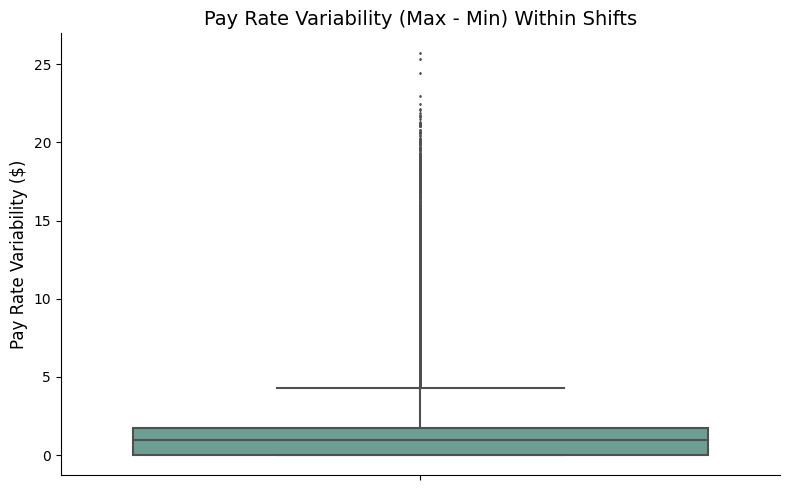

In [8]:
                # ANALYSING PAY RATE VARIABILITY WITHIN A SHIFT

# Convert PAY_RATE to numeric and drop rows with missing PAY_RATE or SHIFT_ID
df['PAY_RATE'] = pd.to_numeric(df['PAY_RATE'], errors='coerce')
df = df.dropna(subset=['SHIFT_ID', 'PAY_RATE'])

# Calculate pay rate range (max - min) per SHIFT_ID
pay_rate_variability = (
    df.groupby('SHIFT_ID')['PAY_RATE']
    .agg(['max', 'min'])
    .reset_index()
    .assign(pay_rate_range=lambda x: x['max'] - x['min'])
)

# --- Summary Statistics ---
summary_stats = pay_rate_variability['pay_rate_range'].describe().round(2)
print("📊 Summary Statistics: Pay Rate Variability (Max - Min) per Shift")
print(summary_stats)

# --- Count of Zero Pay Rate Range ---
zero_range_count = (pay_rate_variability['pay_rate_range'] == 0).sum()
print(f"\n🔹 Number of shifts with zero pay rate range: {zero_range_count}")

# --- PLOTTING ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    y=pay_rate_variability['pay_rate_range'],
    color=sns.color_palette('ch:s=-.5,r=-.1')[2],
    fliersize=1
)

plt.title('Pay Rate Variability (Max - Min) Within Shifts', fontsize=14)
plt.ylabel('Pay Rate Variability ($)', fontsize=12)
plt.xlabel('')
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()


📊 Summary Statistics for Charge Rate, Pay Rate, and Revenue:

       CHARGE_RATE   PAY_RATE    REVENUE
count    266340.00  266340.00  266340.00
mean         31.51      24.16       7.35
std           5.41       4.65       6.36
min          24.00      16.14     -31.48
25%          27.00      21.58       3.67
50%          31.00      22.52       7.63
75%          36.00      25.10      11.06
max          64.00      58.57      35.09

❗ Number of Offers with Revenue Loss: 24,094


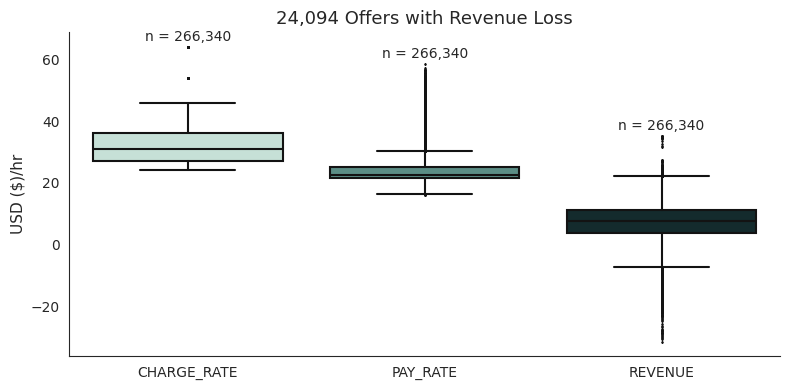

In [12]:
                #ANALYSIS OF CHARGE RATE, PAY RATE  AND ANTICIPATED PROFITS

# 📊 Calculate Revenue as the difference between Charge Rate and Pay Rate
df['REVENUE'] = df['CHARGE_RATE'] - df['PAY_RATE']

# 📈 Summary statistics
summary_stats = df[['CHARGE_RATE', 'PAY_RATE', 'REVENUE']].describe().round(2)
print("📊 Summary Statistics for Charge Rate, Pay Rate, and Revenue:\n")
print(summary_stats)

# ❗ Count of shifts where Pay Rate is greater than or equal to Charge Rate
non_positive_diff_count = (df['REVENUE'] < 0).sum()
print(f"\n❗ Number of Offers with Revenue Loss: {non_positive_diff_count:,}")

# --- PLOTTING ---

# 🎨 Set plot style
sns.set_style("white")
plt.figure(figsize=(8, 4))

# 📦 Prepare long-format data for boxplot
rate_data = pd.melt(
    df[['CHARGE_RATE', 'PAY_RATE', 'REVENUE']],
    var_name='Rate Type',
    value_name='Rate'
)

# 📦 Create boxplot
ax = sns.boxplot(
    data=rate_data,
    x='Rate Type',
    y='Rate',
    palette='ch:s=-.5,r=-.1',
    fliersize=1
)

# 🏷️ Add title
ax.set_title('24,094 Offers with Revenue Loss', fontsize=13)

# ✍️ Customize labels and formatting
ax.set_xlabel('')
ax.set_ylabel('USD ($)/hr', fontsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# ✅ Ensure consistent x-tick labels
rate_types = rate_data['Rate Type'].unique()
ax.set_xticklabels(rate_types, fontsize=10)

# 🧮 Annotate boxplot with counts
counts = rate_data['Rate Type'].value_counts()
for pos, rate_type in enumerate(rate_types):
    count = counts[rate_type]
    y_max = rate_data[rate_data['Rate Type'] == rate_type]['Rate'].max()
    ax.text(pos, y_max + 1, f'n = {count:,}', ha='center', va='bottom', fontsize=10)

# 🧹 Final touch
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()


                         🔍 EXPLORATORY DATA ANALYSIS - BY SLOT TYPE
Summary Statistics for Duration of Shift by Slot Type:

      count  mean   std  min  25%  50%  75%   max
SLOT                                             
AM     7051  8.68  1.75  0.0  8.0  8.0  9.0  17.0
PM     8218  8.29  1.24  0.0  8.0  8.0  8.0  16.0
NOC    4631  8.37  1.11  0.0  8.0  8.0  8.0  18.0




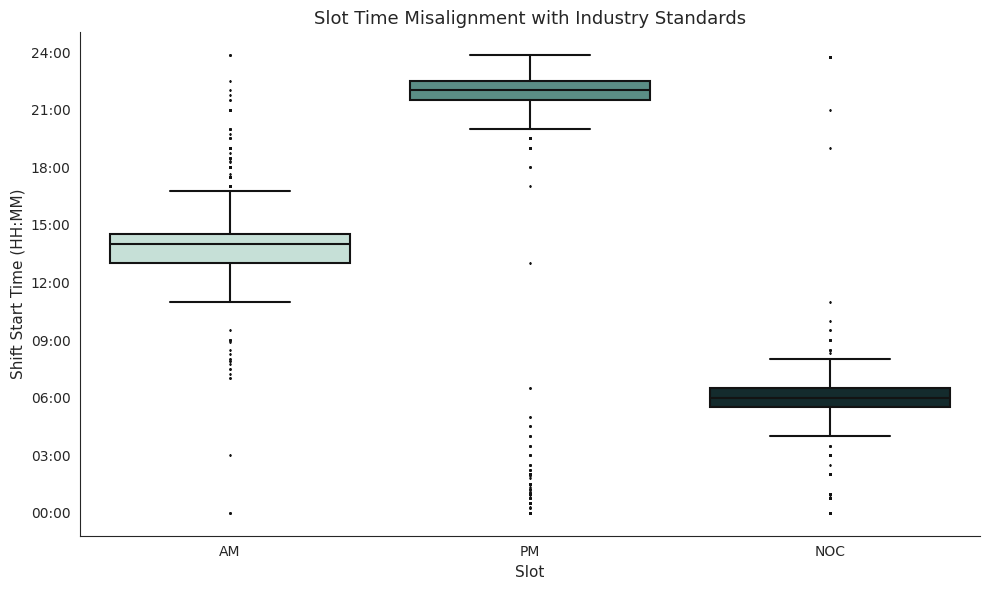

In [13]:
                    # EXPLORATORY DATA ANALYSIS - BY SLOT TYPE

print("=" * 95)
print(" " * 25 + "🔍 EXPLORATORY DATA ANALYSIS - BY SLOT TYPE")
print("=" * 95)

# --- DATA PREPARATION ---

# 🎯 Select relevant columns and remove duplicates at the SHIFT_ID level
df_shifts = df[['SHIFT_ID', 'WORKPLACE_ID', 'SHIFT_START_AT', 'SHIFT_CREATED_AT', 'DURATION', 'SLOT', 'CHARGE_RATE']].drop_duplicates()

# 🕐 Normalize and order the SLOT values
slot_order = ['AM', 'PM', 'NOC']
df_shifts['SLOT'] = pd.Categorical(df_shifts['SLOT'].str.upper(), categories=slot_order, ordered=True)

# 🗓️ Parse shift start time
df_shifts['SHIFT_START_AT'] = pd.to_datetime(df_shifts['SHIFT_START_AT'])

# 📆 Create a shift date column
df_shifts['SHIFT_DATE'] = df_shifts['SHIFT_START_AT'].dt.date

# 📊 Daily shift count by slot
daily_counts = df_shifts.groupby(['SHIFT_DATE', 'SLOT']).size().reset_index(name='shift_count')
daily_counts['SHIFT_DATE'] = pd.to_datetime(daily_counts['SHIFT_DATE'])  # Ensure datetime type for plotting

# --- SUMMARY STATISTICS ---

print("Summary Statistics for Duration of Shift by Slot Type:\n")
summary_stats = df_shifts.groupby('SLOT')['DURATION'].describe()
summary_stats['count'] = summary_stats['count'].astype(int)
summary_stats[['mean', 'std']] = summary_stats[['mean', 'std']].round(2)
print(summary_stats)

print("\n" + "=" * 95 + "\n")

# --- PLOTTING ---

# ⏱️ Convert shift start time to minutes since midnight
df_shifts['SHIFT_TIME_MIN'] = df_shifts['SHIFT_START_AT'].dt.hour * 60 + df_shifts['SHIFT_START_AT'].dt.minute
df_shifts['SHIFT_TIME_STR'] = df_shifts['SHIFT_START_AT'].dt.strftime('%H:%M')  # Optional readable format

# 📦 Boxplot of Shift Start Time by Slot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_shifts, x='SLOT', y='SHIFT_TIME_MIN', palette='ch:s=-.5,r=-.1', fliersize=1)

# 🕓 Format y-axis as HH:MM
def format_minutes(x, _):
    return f"{int(x // 60):02d}:{int(x % 60):02d}"

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(180))  # Show ticks every 3 hours
ax.yaxis.set_major_formatter(FuncFormatter(format_minutes))

# 📌 Labels and title
ax.set_title('Slot Time Misalignment with Industry Standards', fontsize=13)
ax.set_xlabel('Slot', fontsize=11)
ax.set_ylabel('Shift Start Time (HH:MM)', fontsize=11)

sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()


**Slots:**


* Across the three time slots, the highest number of shifts were created for the PM slot (8,218), followed by AM (7,051), and then NOC (4,631).

* On average, shifts across all three slots lasted 8 hours, with durations ranging from 0 to 18 hours, showing a similar distribution across slots.

******   Further investigation should be done on the zero-hour shifts.********

**Slot start time in this dataset Vs Standard slot start times**

•	The interquartile range (25th-75th percentile) of shift start times for AM shifts falls between 13:00 and 14:30, for PM shifts between 21:30 and 22:30, and for NOC shifts between 05:30 and 06:30. 

•	However, these observed slot times do not align with standard shift start times commonly used in the healthcare and staffing industries, where AM shifts typically begin between 07:00 and 08:00, PM shifts between 15:00 and 16:00, and NOC shifts between 23:00 and 00:00. 

******   Reasons for inconsistencies in slot labeling should be investigated and corrected. *****  * 

Example image showing AM shifts starting at 13 h or later

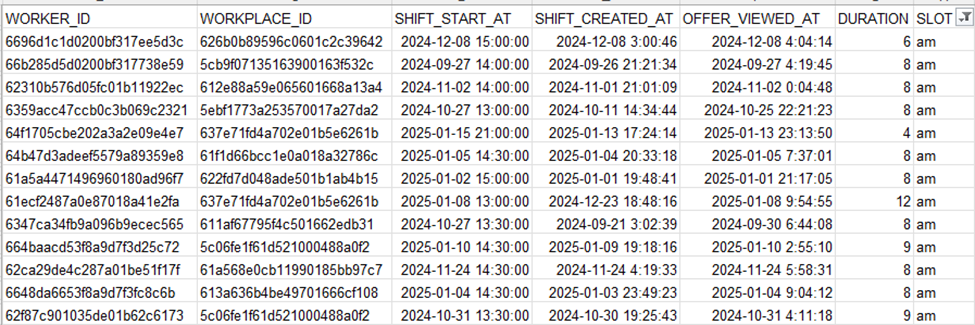

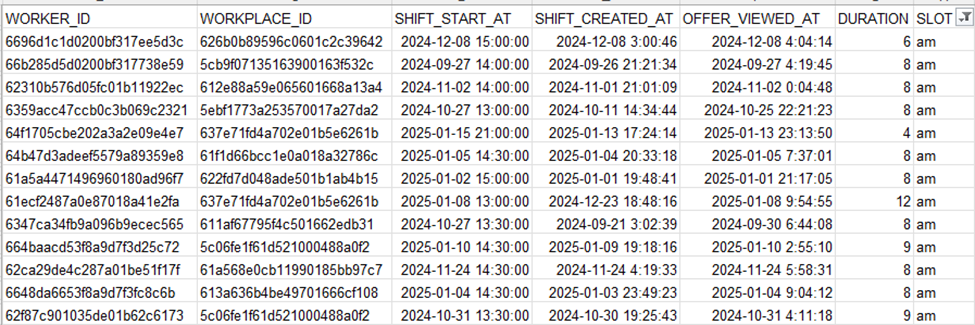

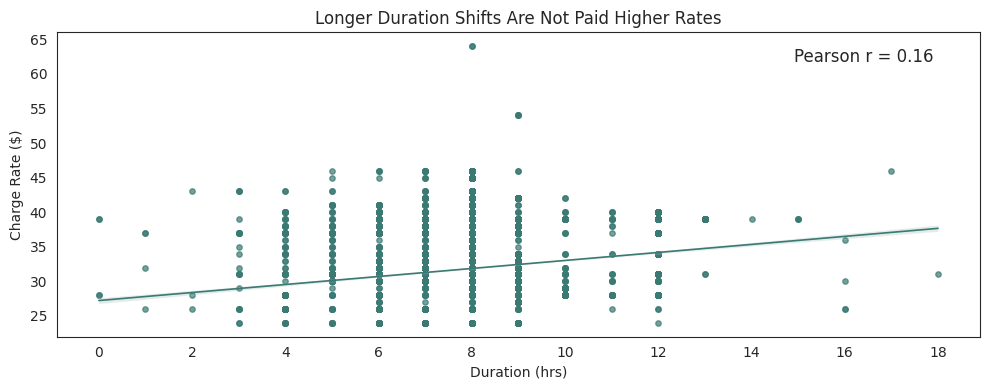

In [9]:
         # EXPLORATORY DATA ANALYSIS - IDENTIFYING IF LONGER SHIFTS ARE PAID HIGHER

# Calculate Pearson correlation
corr_coef, _ = pearsonr(df_shifts['DURATION'], df_shifts['CHARGE_RATE'])

# Choose color
dot_color = sns.color_palette('ch:s=-.5,r=-.1,l=0.4', n_colors=1)[0]

# Set up plot
plt.figure(figsize=(10, 4))
sns.regplot(
    data=df_shifts,
    x='DURATION',
    y='CHARGE_RATE',
    scatter_kws={'s': 15, 'alpha': 0.7, 'color': dot_color},
    line_kws={'color': dot_color, 'linewidth': 1.2}
)

# Set even-numbered x-axis ticks **after the plot is made**
max_duration = df_shifts['DURATION'].max()
even_ticks = np.arange(0, max_duration + 2, 2)
plt.xticks(even_ticks)

# Add Pearson correlation on the top-right corner
plt.text(
    0.95, 0.95,
    f'Pearson r = {corr_coef:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right',
    va='top'
)

plt.title('Longer Duration Shifts Are Not Paid Higher Rates')
plt.xlabel('Duration (hrs)')
plt.ylabel('Charge Rate ($)')
plt.tight_layout()
plt.show()

Shift duration & Charge rate
•	On average, shifts across all three slots lasted 8 hours, with durations ranging from 0 to 18 hours, showing a similar distribution across slots.
•	The average charge rate per hour is $32 USD and remains consistent across the slots. However, a few shifts were charged at significantly higher rates, with three shifts reaching $54 USD per hour, and one shift at $65 USD.
•	Multiple charge rates exist for the same shift durations, indicating that charge rate is likely influenced by factors, such as job type or required skillset.
•	Further investigation should be done on the zero-hour shifts.


                    🔍 EXPLORATORY DATA ANALYSIS  - SLOT TYPE & DAY OF WEEK


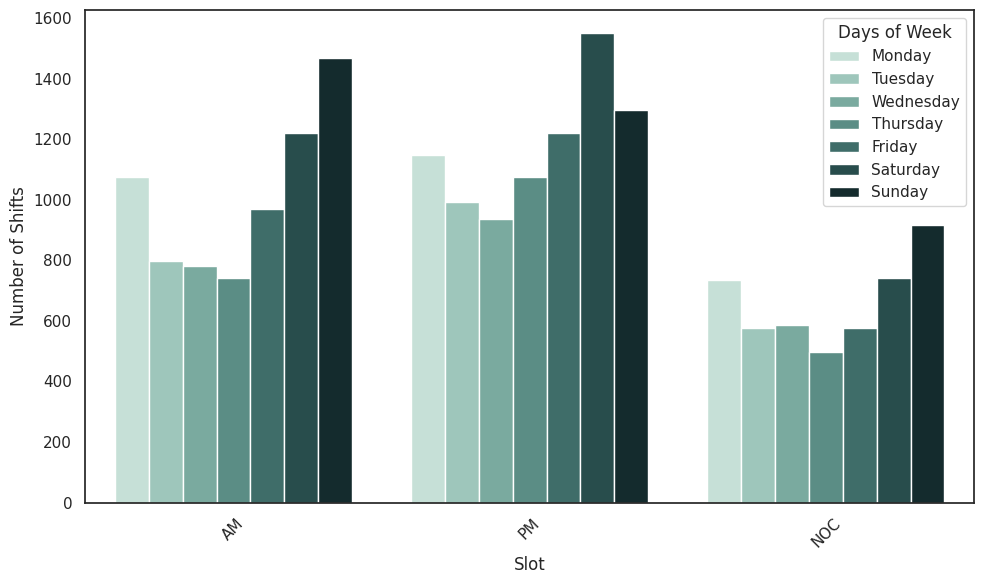

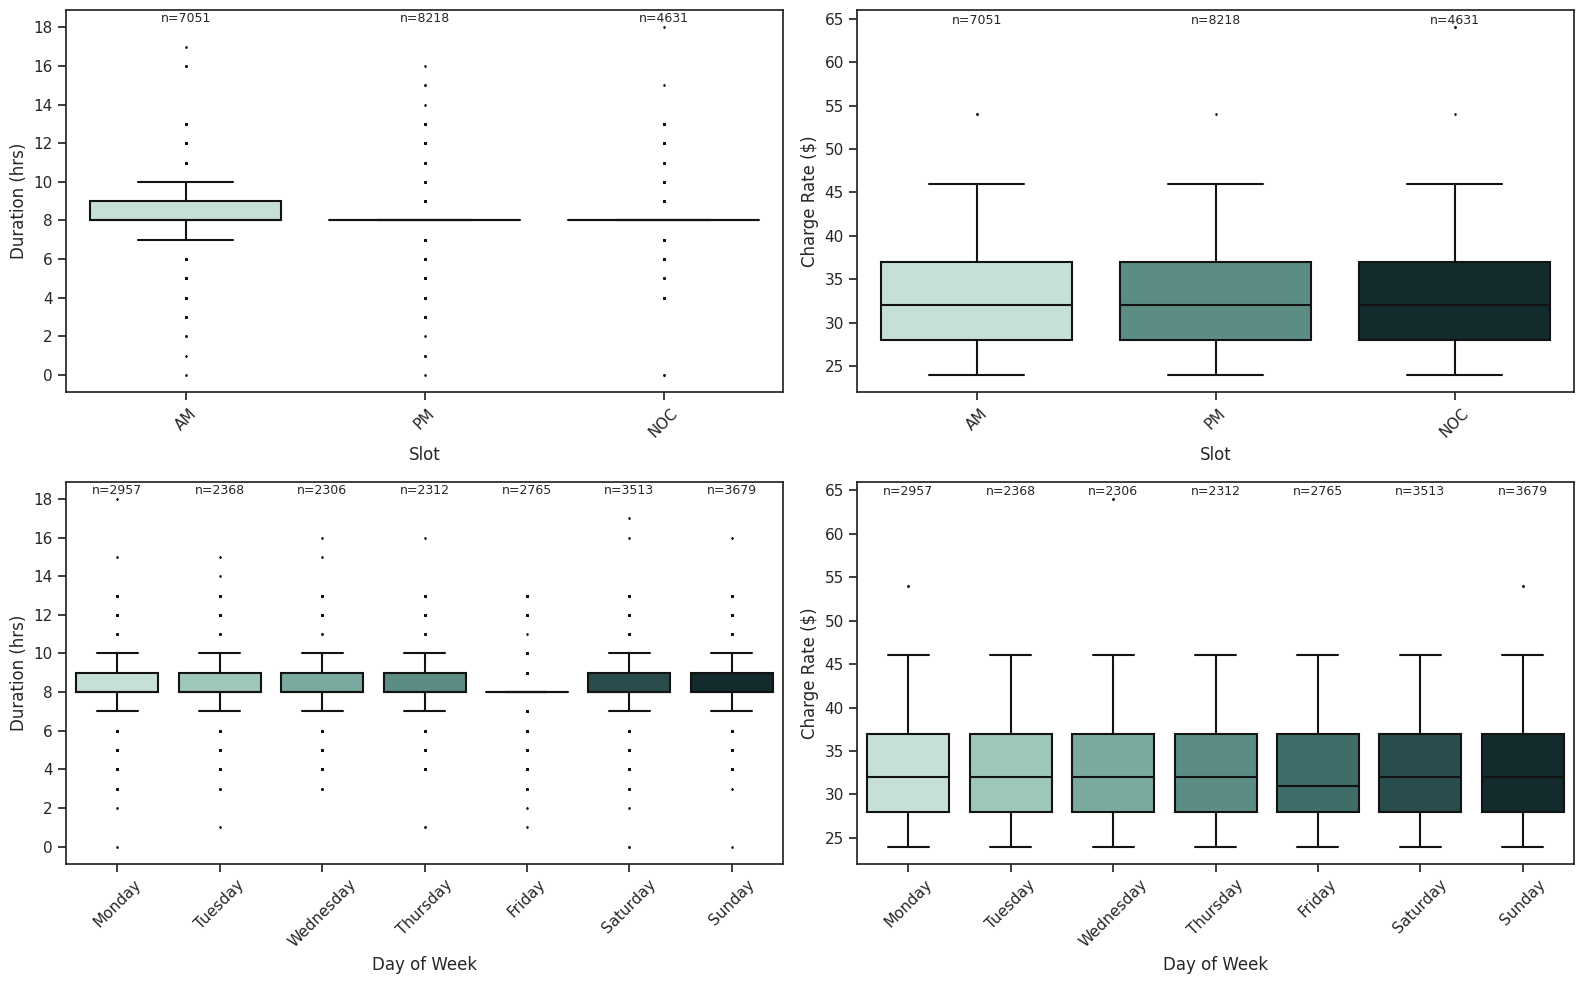

In [10]:
                # EXPLORATORY DATA ANALYSIS - SLOT TYPE & DAY OF WEEK

print("="*95)
print(" "*20 + "🔍 EXPLORATORY DATA ANALYSIS  - SLOT TYPE & DAY OF WEEK")
print("="*95)
# Set minimal style
sns.set(style="white")

# Prepare shift data
df_shifts = df[['SHIFT_ID', 'WORKPLACE_ID', 'SHIFT_START_AT', 'SHIFT_CREATED_AT', 'DURATION', 'SLOT', 'CHARGE_RATE']].drop_duplicates()

# Define slot and day order
slot_order = ['AM', 'PM', 'NOC']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Clean and categorize columns
df_shifts['SLOT'] = df_shifts['SLOT'].str.upper()
df_shifts['SLOT'] = pd.Categorical(df_shifts['SLOT'], categories=slot_order, ordered=True)
df_shifts['day_of_week'] = pd.Categorical(df_shifts['SHIFT_START_AT'].dt.day_name(), categories=day_order, ordered=True)

# ----- Bar Plot: Shift Count by Day of Week and Slot -----
weekly_counts = df_shifts.groupby(['day_of_week', 'SLOT']).size().reset_index(name='shift_count')

plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_counts, x='SLOT', y='shift_count', hue='day_of_week', palette='ch:s=-.5,r=-.1')
plt.xlabel('Slot')
plt.ylabel('Number of Shifts')
plt.xticks(rotation=45)
plt.legend(title='Days of Week')
plt.tight_layout()
plt.show()

# ----- Box Plots: Duration and Charge Rate by Slot and Day of Week -----
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=False)

# Boxplot 1: Duration by Slot
sns.boxplot(data=df_shifts, x='SLOT', y='DURATION', order=slot_order,
            ax=axes[0, 0], palette='ch:s=-.5,r=-.1', fliersize=1)
axes[0, 0].set_xlabel('Slot')
axes[0, 0].set_ylabel('Duration (hrs)')
axes[0, 0].yaxis.set_major_locator(MultipleLocator(2))
duration_counts_slot = df_shifts.groupby('SLOT')['DURATION'].count().reindex(slot_order)
for i, count in enumerate(duration_counts_slot):
    axes[0, 0].text(i, df_shifts['DURATION'].max() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=9)

# Boxplot 2: Charge Rate by Slot
sns.boxplot(data=df_shifts, x='SLOT', y='CHARGE_RATE', order=slot_order,
            ax=axes[0, 1], palette='ch:s=-.5,r=-.1', fliersize=1)
axes[0, 1].set_xlabel('Slot')
axes[0, 1].set_ylabel('Charge Rate ($)')
charge_counts_slot = df_shifts.groupby('SLOT')['CHARGE_RATE'].count().reindex(slot_order)
for i, count in enumerate(charge_counts_slot):
    axes[0, 1].text(i, df_shifts['CHARGE_RATE'].max() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=9)

# Boxplot 3: Duration by Day of Week
sns.boxplot(data=df_shifts, x='day_of_week', y='DURATION', order=day_order,
            ax=axes[1, 0], palette='ch:s=-.5,r=-.1', fliersize=1)
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Duration (hrs)')
axes[1, 0].yaxis.set_major_locator(MultipleLocator(2))
duration_counts_day = df_shifts.groupby('day_of_week')['DURATION'].count().reindex(day_order)
for i, count in enumerate(duration_counts_day):
    axes[1, 0].text(i, df_shifts['DURATION'].max() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=9)

# Boxplot 4: Charge Rate by Day of Week
sns.boxplot(data=df_shifts, x='day_of_week', y='CHARGE_RATE', order=day_order,
            ax=axes[1, 1], palette='ch:s=-.5,r=-.1', fliersize=1)
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Charge Rate ($)')
charge_counts_day = df_shifts.groupby('day_of_week')['CHARGE_RATE'].count().reindex(day_order)
for i, count in enumerate(charge_counts_day):
    axes[1, 1].text(i, df_shifts['CHARGE_RATE'].max() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=9)

# Clean axes
for ax in axes.flat:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("dur_charge.png", dpi=300)
plt.show()


Shift count by day of week 
•	The highest number of shifts were available for Sunday for the AM (1,467) and NOC (916) slots, and for Saturday for the PM slot (1,549). 
•	The lowest number of shifts were available for Thursday for the AM (741) and NOC (496) slots, and for Wednesday for the PM slot (938). 
•	Overall, there is a clear trend of higher shift volumes during weekends , followed by a gradual decline, reaching the lowest on Wednesdays and Thursdays.	


In [15]:
            #DATA VALIDATION - ASSESSING IF EACH SHIFT IS CLAIMED ONLY ONCE

# --- Keep Valid Shifts ---
# Identify valid shifts by removing the shift ids in df_shifts_filtered
df_unmatched = pd.merge(df, df_shifts_filtered[['SHIFT_ID']], on='SHIFT_ID', how='left', indicator=True)
df_valid = df_unmatched[df_unmatched['_merge'] == 'left_only'].drop(columns=['_merge'])

print("Number of valid shifts:", df_valid['SHIFT_ID'].nunique())
print("(After deleting the shifts that have been posted after the start of the shift)")

# --- Compute Claims per Shift ---
df_claims = df_valid.groupby('SHIFT_ID')['CLAIMED_AT'].count().reset_index(name='claims_count')

print("\n--- All Valid Shifts ---")
print("Total number of valid shifts:", df_claims.shape[0])
print(df_claims['claims_count'].describe().round(2))
print(df_claims.head(1))

# --- Unclaimed Shifts ---
df_unclaimed = df_claims[df_claims['claims_count'] == 0]
print("\n--- Unclaimed Shifts ---")
print("Total valid & unclaimed shifts:", df_unclaimed.shape[0])
print(df_unclaimed['claims_count'].describe().round(2))

# --- Shifts Claimed Atleast Once ---
df_claimed_atleastonce = df_claims[df_claims['claims_count'] >= 1]

# --- Shifts Claimed Once ---
df_claimed_once = df_claims[df_claims['claims_count'] == 1]
print("\n--- Shifts Claimed Once ---")
print("Total valid shifts claimed once:", df_claimed_once.shape[0])
print(df_claimed_once['claims_count'].describe().round(2))

# --- Shifts Claimed More Than Once ---
df_claimed_more_than_once = df_claims[df_claims['claims_count'] > 1]
print("\n--- Shifts Claimed More Than Once ---")
print("Total valid shifts claimed more than once:", df_claimed_more_than_once.shape[0])
print(df_claimed_more_than_once['claims_count'].describe().round(2))


Number of valid shifts: 19853
(After deleting the shifts that have been posted after the start of the shift)

--- All Valid Shifts ---
Total number of valid shifts: 19853
count    19853.00
mean         0.66
std          0.50
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          4.00
Name: claims_count, dtype: float64
                   SHIFT_ID  claims_count
0  66a7d30ba08ab904ae996678             2

--- Unclaimed Shifts ---
Total valid & unclaimed shifts: 7098
count    7098.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: claims_count, dtype: float64

--- Shifts Claimed Once ---
Total valid shifts claimed once: 12504
count    12504.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: claims_count, dtype: float64

--- Shifts Claimed More Than Once ---
Total valid shifts claimed more than once: 251
count    251.00

In [12]:
            # ASSESSING WORKPLACE-INITIATED DELETED SHIFTS BY CLAIM STATUS

# Filter deleted shifts and remove duplicates
df_deleted = df.dropna(subset=['DELETED_AT']).drop_duplicates(subset='SHIFT_ID')

# Confirm NaT values
#nat_values = df_deleted['DELETED_AT'].isna().sum()
#print(f"NaT values in 'DELETED_AT': {nat_values}")

# Total deleted shifts
print("Total deleted shifts by the workplace:", df_deleted.shape[0])

# Calculate deletion timing relative to shift start (in days)
df_deleted['int_del_days'] = (df_deleted['SHIFT_START_AT'] - df_deleted['DELETED_AT']).dt.total_seconds() / (24 * 3600)

# --- Claimed & Deleted Shifts ---
df_claim_del = pd.merge(df_claimed_atleastonce[['SHIFT_ID']], df_deleted, on='SHIFT_ID', how='inner')
print("\n--- Claimed and Deleted Shifts ---")
print("Number of claimed and deleted shifts:", df_claim_del['SHIFT_ID'].nunique())
#print("Total rows in matched dataset:", df_claim_del.shape[0])

# Claimed shifts deleted before their start
df_claim_del_before_start = df_claim_del[df_claim_del['int_del_days'] > 0]
print(f"⚠️ Claimed shifts deleted before the shift started: {df_claim_del_before_start.shape[0]}")

# Claimed shifts deleted after or at their start
df_claim_del_after_start = df_claim_del[df_claim_del['int_del_days'] <= 0]
print(f"⚠️ Claimed shifts deleted after the shift started: {df_claim_del_after_start.shape[0]}")

# --- Unclaimed & Deleted Shifts ---
df_unclaim_del = pd.merge(df_unclaimed[['SHIFT_ID']], df_deleted, on='SHIFT_ID', how='inner')
print("\n--- Unclaimed and Deleted Shifts ---")
print("Number of unclaimed and deleted shifts:", df_unclaim_del['SHIFT_ID'].nunique())
#print("Total rows in matched dataset:", df_unclaim_del.shape[0])

# Unclaimed shifts deleted before their start
df_unclaim_del_before_start = df_unclaim_del[df_unclaim_del['int_del_days'] > 0]
print(f"⚠️ Unclaimed shifts deleted before the shift started: {df_unclaim_del_before_start.shape[0]}")

# Unclaimed shifts deleted after or at their start
df_unclaim_del_after_start = df_unclaim_del[df_unclaim_del['int_del_days'] <= 0]
print(f"⚠️ Unclaimed shifts deleted after the shift started: {df_unclaim_del_after_start.shape[0]}")


Total deleted shifts by the workplace: 3671

--- Claimed and Deleted Shifts ---
Number of claimed and deleted shifts: 192
⚠️ Claimed shifts deleted before the shift started: 184
⚠️ Claimed shifts deleted after the shift started: 8

--- Unclaimed and Deleted Shifts ---
Number of unclaimed and deleted shifts: 3479
⚠️ Unclaimed shifts deleted before the shift started: 3407
⚠️ Unclaimed shifts deleted after the shift started: 72


In [16]:
                # ANALYSING SHIFT CANCELATIONS AND NO CLAIMS

# Merge df_claimed_atleastonce with df to keep matched records
df_merged_claimed = pd.merge(df_claimed_atleastonce[['SHIFT_ID']], df, on='SHIFT_ID', how='inner')

# Count non-null CANCELED_AT values per SHIFT_ID
cancel_counts = df_merged_claimed.dropna(subset=['CANCELED_AT']) \
                                 .groupby('SHIFT_ID') \
                                 .size() \
                                 .reset_index(name='cancel_count')

# Display the results
print("Total claimed shifts with cancellations:", cancel_counts.shape[0])
# Top 5 SHIFT_IDs with highest cancel counts
top_5_cancellations = cancel_counts.sort_values(by='cancel_count', ascending=False).head(5)

print("Top 5 SHIFT_IDs with the highest number of cancellations:")
print(top_5_cancellations)
# Summary statistics for cancel_count
summary_cancel_counts = cancel_counts['cancel_count'].describe().round(2)

# Display
print("Summary statistics for number of cancellations per claimed shift:")
print(summary_cancel_counts)
# Filter for cancel_count > 1
multiple_cancels = cancel_counts[cancel_counts['cancel_count'] > 1]

# Output the number of such shifts
print("🔁 Number of SHIFT_IDs with more than 1 cancellation:", len(multiple_cancels))

ncns_count = df[df['IS_NCNS'] == True].shape[0]
print("🚫 Number of No-Call No-Show (NCNS) shifts:", ncns_count)

Total claimed shifts with cancellations: 269
Top 5 SHIFT_IDs with the highest number of cancellations:
                     SHIFT_ID  cancel_count
41   66fda9938660269a71681ba7             4
148  673e2d9d8df465cf94dbd202             3
38   66fcba4b86cd008f19411a31             3
145  673cee879582524577d55d86             2
65   67095a2437c8617d291e5cde             2
Summary statistics for number of cancellations per claimed shift:
count    269.00
mean       1.19
std        0.44
min        1.00
25%        1.00
50%        1.00
75%        1.00
max        4.00
Name: cancel_count, dtype: float64
🔁 Number of SHIFT_IDs with more than 1 cancellation: 48
🚫 Number of No-Call No-Show (NCNS) shifts: 31
